In [1]:
#from src.utils.results_utils import *
from src.utils.data_utils import str_dict_to_values
from src.utils.ml_utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import pickle

[nltk_data] Error loading words: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading names: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


## Load and clean the dataset

In [2]:
df_ml = pd.read_csv('data/cleaned.csv')
df_ml['Country'] = df_ml['Country'].apply(str_dict_to_values)
df_ml['Genres'] = df_ml['Genres'].apply(str_dict_to_values)


In [3]:
df_ml.drop(columns=['Wikipedia_ID','Name','Languages','Release_date'],inplace=True)
df_ml.head()

,Country,Genres,Character_name,Sex,Actor_age
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,42.0
1,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,27.0
2,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,32.0
3,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,33.0
4,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,23.0


In [4]:
#Replace Actor_age column by ages groups for simplicity

age_bins = [0,17, 34, 54, 74, 100]
age_labels = [
            '<17y', '18y-34y', '34y-54y', '55y-74y', '>75y']

df_ml['age_category'] = pd.cut(df_ml['Actor_age'], bins=age_bins, labels=age_labels, right=False)
df_ml.drop(columns=['Actor_age'],inplace=True)

In [5]:
get_vowel_stats(df_ml, 'Character_name')
df_ml.head()

,Country,Genres,Character_name,Sex,age_category,vowel_count,consonant_count,name_length
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,34y-54y,5,3,8
1,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,18y-34y,4,3,7
2,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,18y-34y,3,5,8
3,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,18y-34y,3,4,7
4,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,18y-34y,3,4,7


In [6]:
find_unusual_characters(df_ml,'Character_name')

Number of rows containing special characters: 2055
Unusual Characters Found: {'ð', 'Ø', 'É', 'Á', 'ò', 'á', 'å', '-', 'ü', 'û', 'Ö', 'þ', 'ç', 'ø', 'È', 'Â', 'À', 'ã', 'ï', 'Ó', 'ê', 'ś', 'à', 'ß', 'ä', 'è', 'ö', 'ł', 'ù', 'î', 'ý', 'ô', 'Å', 'ó', 'ì', 'Õ', 'â', 'í', 'é', 'Þ', 'æ', 'Í', 'ë', 'ú', 'ñ', 'Ô', 'ž', 'õ', 'ō', 'š', 'ū'}


In [7]:
def plot_special_character_distribution(df, column_name, allowed_chars='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    """
    Generate a Seaborn barplot showing the number of rows containing each type of special character.

    Parameters:
        df (pd.DataFrame): The dataset containing the column.
        column_name (str): The name of the column to analyze.
        allowed_chars (str): A string of allowed characters.
    """
    allowed_set = set(allowed_chars)
    
    # Initialize a counter for special characters
    special_char_counts = Counter()
    
    # Count special characters per row
    for value in df[column_name].dropna().astype(str):
        special_chars = set(value) - allowed_set
        special_char_counts.update(special_chars)
    
    # Convert to a DataFrame for plotting
    special_char_df = pd.DataFrame.from_dict(special_char_counts, orient='index', columns=['Count']).reset_index()
    special_char_df.columns = ['Special Character', 'Count']
    
    # Plot the distribution using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=special_char_df, x='Special Character', y='Count')
    plt.title('Distribution of Special Characters')
    plt.xlabel('Special Character')
    plt.ylabel('Number of Rows Containing Character')
    plt.show()

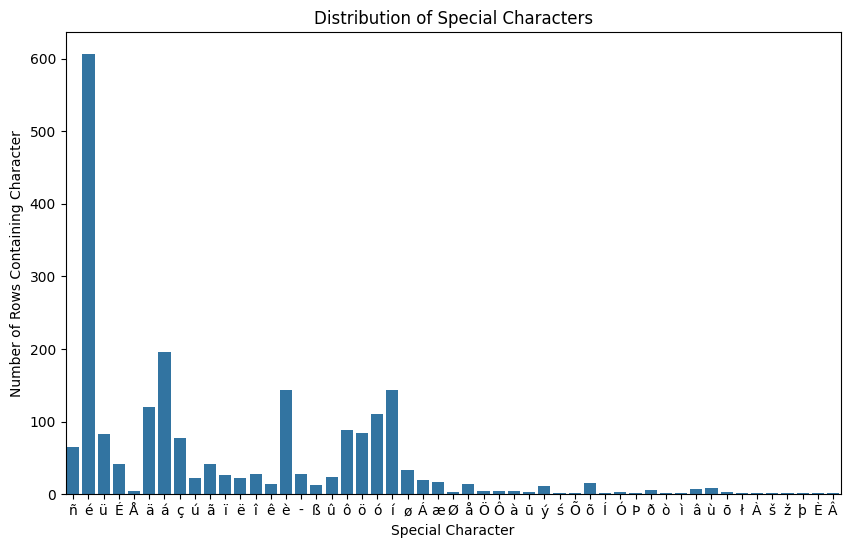

In [8]:
plot_special_character_distribution(df_ml,'Character_name')

We will add the most frequent special character to the alphabet: 'é', 'è', 'á' and 'í'

In [9]:
augmented_alphabet = 'abcdefghijklmnopqrstuvwxyzéèíá'

In [10]:
character_processor = NameFeatureProcessor('Character_name', ngram_range = (2,2))

df_ml = character_processor.process(df_ml,alphabet = augmented_alphabet,analyze_name = False, diacritic = False, phonetics = False, first_last = True, ngram=False)
df_ml.head()

,Country,Genres,Character_name,Sex,age_category,vowel_count,consonant_count,name_length,a_f,b_f,...,u_l,v_l,w_l,x_l,y_l,z_l,é_l,è_l,í_l,á_l
0,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,34y-54y,5,3,8,1,0,...,0,0,0,0,1,0,0,0,0,0
1,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,18y-34y,4,3,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,18y-34y,3,5,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,18y-34y,3,4,7,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,18y-34y,3,4,7,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
vectorizer = HashingVectorizer(analyzer='char', ngram_range=(2, 3), n_features=100)  
ngram_features = vectorizer.fit_transform(df_ml['Character_name'])
n_gram_df = pd.DataFrame(ngram_features.toarray())
df_ml = pd.concat([df_ml, n_gram_df], axis=1)


In [12]:
with open('hashing_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)

## Gender Predictions

In [13]:
gender_predictor = PredictorModel(df_ml,'Sex')

df_gender = gender_predictor.clean_df()

In [14]:
rows_with_nans = df_gender.isna().any(axis=1).sum()
print(rows_with_nans)

5506


We drop the rows with NaNs

In [15]:
df_gender = df_gender.dropna()

In [ ]:
gender_predictor.train(df_gender,f1=True, balancing=False)

In [17]:
gender_predictor.create_and_predict('Louis')
    

Prediction:  ['45y-54y']


## Age Prediction

In [18]:
age_predictor = PredictorModel(df_ml,'age_category')

df_age = age_predictor.clean_df()

In [19]:
df_age = df_age.dropna()

Train

In [20]:
age_predictor.train(df_age,f1=True,balancing=True)

              precision    recall  f1-score   support

     18y-34y       0.46      0.32      0.38      4650
     34y-54y       0.46      0.35      0.40      4856
     55y-74y       0.15      0.22      0.18      1395
        <17y       0.07      0.30      0.11       466
        >75y       0.03      0.10      0.05       135

    accuracy                           0.32     11502
   macro avg       0.23      0.26      0.22     11502
weighted avg       0.40      0.32      0.35     11502

Accuracy: 0.317


In [28]:
age_predictor.create_and_predict('Dorothy')

Prediction:  ['55y-74y']
